In [1]:
from run_ablation import cfg_to_training_params, parse_set_kv
from ablation_configs import ABLATIONS
import argparse, copy, json, os
from flax.training import checkpoints
from train import Trainer 
import numpy as np
import matplotlib.pyplot as plt
import jax.numpy as jnp

/home/silpasoninallacheruvu/mean-flows/venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/silpasoninallacheruvu/mean-flows/venv/lib/python3.11/site-packages/torch/amp/autocast_mode.py:270: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Flax classes are deprecated and will be removed in Diffusers v1.0.0. We recommend migrating to PyTorch classes or pinning your version of Diffusers.
Flax classes are deprecated and will be removed in Diffusers v1.0.0. We recommend migrating to PyTorch classes or pinning your version of Diffusers.


In [2]:
# Utility to unnormalize ImageNet images for display
IMAGENET_MEAN = np.array([0.485, 0.456, 0.406], dtype=np.float32)
IMAGENET_STD  = np.array([0.229, 0.224, 0.225], dtype=np.float32)

def unnormalize(img: np.ndarray) -> np.ndarray:
    """
    img: [H, W, 3] normalized image
    return: [H, W, 3] unnormalized back to [0,1]
    """
    return np.clip(img * IMAGENET_STD + IMAGENET_MEAN, 0, 1)


def show_batch(images: np.ndarray, n=4, output_path="/home/silpasoninallacheruvu/mean-flows/results/generated_images.png"):
    """
    Display a grid of N images.
    images: [N, H, W, 3]
    """ 
    plt.figure(figsize=(12, 12))
    for i in range(min(n, images.shape[0])):
        plt.subplot(4, 4, i + 1)
        img = images[i]                  # (H,W,3)
        img = unnormalize(img)
        plt.imshow(img)
        plt.axis("off")
    plt.tight_layout()
    plt.savefig(output_path, dpi=150, bbox_inches='tight')
    plt.show()
    plt.close()
    

In [3]:
base_cfg = copy.deepcopy(ABLATIONS["best"])
tp = cfg_to_training_params(base_cfg)
tp

TrainingParams(architecture='DiT-B-4', epochs=30, lr=0.0001, beta1=0.9, beta2=0.95, ema_decay=0.9999, p=0.5, omega=1.5, ratio_r_not_eq_t=1.0, jvp_computation=(False, True), embed_t_r_name='tr_t_tr', embed_t_r=<function <lambda> at 0x7f4130196840>, time_embed_dim=3, time_sampler_params=(-0.4, 1.2))

In [4]:
ckpt_dir = "/home/silpasoninallacheruvu/mean-flows/runs/ablations/single/checkpoints/"
latest = checkpoints.latest_checkpoint(ckpt_dir)
if latest is not None:
    print(f"[run_ablation] Found existing checkpoint: {latest}")
    resume = True

trainer = Trainer(
    tp,
    checkpoint_dir=ckpt_dir,
    resume_from_checkpoints=resume,
)

[run_ablation] Found existing checkpoint: /home/silpasoninallacheruvu/mean-flows/runs/ablations/single/checkpoints/checkpoint_49.pkl
Loading cached Inception weights from /home/silpasoninallacheruvu/mean-flows/data/jax_fid/inception_weights.pkl
[info (VAETokenizer)] CUDA unavailable, falling back to CPU


/home/silpasoninallacheruvu/mean-flows/venv/lib/python3.11/site-packages/huggingface_hub/utils/_validators.py:202: UserWarning: The `local_dir_use_symlinks` argument is deprecated and ignored in `hf_hub_download`. Downloading to a local directory does not use symlinks anymore.
  warnings.warn(


VAE scaling factor: 0.18215


In [6]:
run_dir = "/home/silpasoninallacheruvu/mean-flows/runs/ablations/single/"
old_cwd = os.getcwd()
try:
    os.chdir(run_dir)
    trained_params = trainer.train()
    final_fid = trainer.eval_fid(trained_params, num_samples=1000)
    print(f"FID-1K value is : {final_fid}")
finally:
    os.chdir(old_cwd)

[info (get_dataloaders_extracted())] Using unlabeled validation images.
[ImageNet extracted] train=5000 images, val=500 images
[Trainer] Loaded checkpoint from /home/silpasoninallacheruvu/mean-flows/runs/ablations/single/checkpoints/checkpoint_29.pkl
[Trainer] Resumed full state from /home/silpasoninallacheruvu/mean-flows/runs/ablations/single/checkpoints
FID-1K value is : 120.21968078613281


generated image shape : (8, 256, 256, 3)


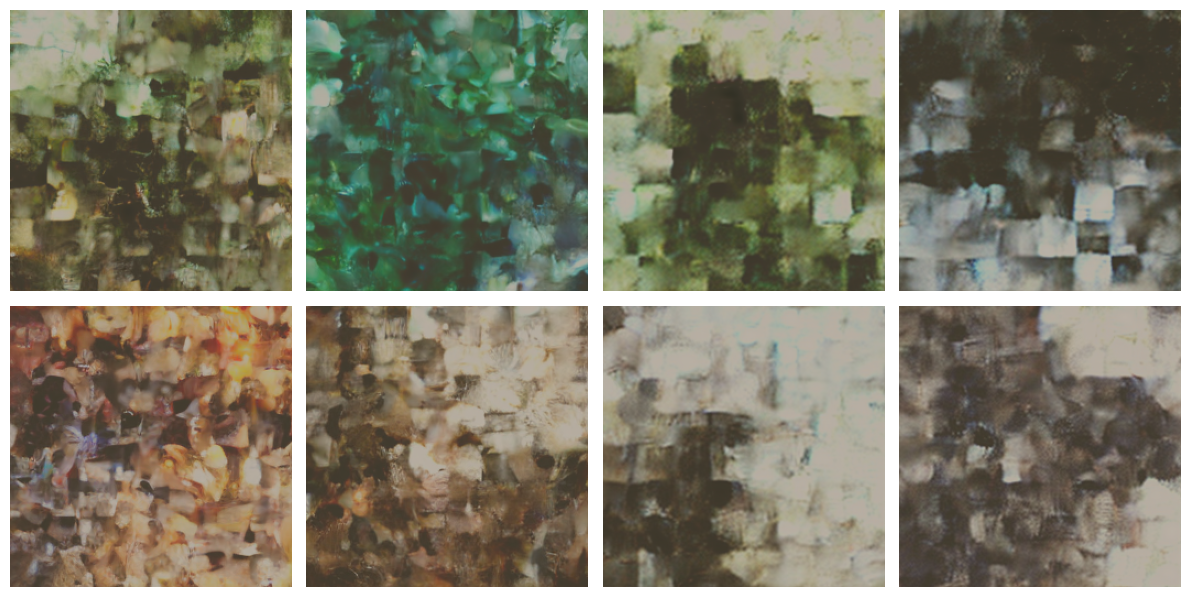

In [10]:
num_samples=8
for imgs_np in trainer.generate_samples(trained_params, num_samples=num_samples, batch_size=num_samples, seed=3456, c=None):
    print(f"generated image shape : {imgs_np.shape}")
    show_batch(imgs_np,num_samples)
